<div dir='rtl'>
<h2> K-means vs GMM (۳۰ نمره)</h2> 


---


در این تمرین قصد داریم دو روش 
kmeans 
و 
GMM
را بدون استفاده از کتابخانه‌های آماده پیاده‌سازی کنیم. 

برای پیاده‌سازی GMM
می‌توانید از تابع نرمال چند متغیره که در 
<code> scipy </code>
است، استفاده کنید.

</div>

<div dir='rtl'>

برای پیاده‌سازی الگوریتم 
K-means
کار را تا جایی ادامه دهید که مرکز خوشه‌ها تغییر نکند.

در پیاده‌سازی الگوریتم GMM
هم تا جایی پیش‌بروید که تفاوت درست‌نمایی در دو دور متوالی کمتر از ۰.۱ باشد.

</div>

<div dir='rtl'>
<h4> الف (۲۰ نمره)</h4>

با استفاده از تابع زیر دیتاست را ایجاد کنید. سپس برای
K=2
دو الگوریتم را روی دیتاست اجرا کنید. 

کیفیت روش‌های پیاده‌سازی شده را با استفاده از دو معیار 
<code> purity </code>
و 
<code> rand-index </code>
با یکدیگر مقایسه کنید.


---


در روش K-means
بهتر است اجرا چند بار انجام شود و بهترین نتیجه گزارش شود.
</div>

In [239]:
import numpy as np
from scipy.stats import multivariate_normal as sp_multi_norm
from scipy.special import comb
import pandas as pd
import matplotlib.pyplot as plt
import copy
from sklearn.datasets import make_classification

In [118]:
class Measurement():
    
    def purity(self, target, predicted):
        df_con = pd.crosstab(pd.Series(target, name='target'), pd.Series(predicted, name='predicted'))
        con_matrix = df_con.to_numpy()
        
        return np.sum(np.amax(con_matrix, axis = 0)) / np.sum(con_matrix)
    
    def rand_index(self, clusters, classes):
        tp_fp = comb(np.bincount(clusters), 2).sum()
        tp_fn = comb(np.bincount(classes), 2).sum()
        A = np.c_[(clusters, classes)]
        tp = sum(comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum()
                 for i in set(clusters))
        fp = tp_fp - tp
        fn = tp_fn - tp
        tn = comb(len(A), 2) - tp - fp - fn
        return (tp + tn) / (tp + fp + fn + tn)

In [201]:
class KMean:
    
    def __init__(self, X, fetures, class_count, iteration_count):
        self.X = X
        self.n = len(self.X)
        self.fetures = fetures
        self.class_count = class_count
        self.iteration_count = iteration_count
#         print('ok')
#         print(self.X.shape)
#         print(self.fetures)
#         print(self.class_count)
#         print(self.iteration_count)
        
    def predict(self,ms):
        n = self.n
        k = self.class_count
        predict = [-1 for i in range(n)]
        for i in range(n):
            min_distance = np.Inf
            for j in range(k):
                l = np.linalg.norm(self.X[i] - ms[j])
                if l < min_distance:
                    predict[i] = j
                    min_distance = l
                
        return(predict)
    
    def calculate_ms(self,ms,predict):
        n = self.n
        k = self.class_count
        sums = np.zeros((k, self.fetures))
        counts = np.zeros((k,))
        for i in range(n):
            idx = predict[i] # idx = class idx
            sums[idx] += X[i]
            counts[idx] += 1
        
        ms = np.zeros((k, self.fetures))
        for j in range(k):
            ms[j] = sums[j] / counts[j]
        
        return ms
    
    def error(self,ms):
        p = self.predict(ms)
        j = 0
        n = self.n
        for i in range(n):
            j += (np.linalg.norm(self.X[i] - ms[p[i]])) ** 2

        return j
    
    def kmean(self):
        minError = np.Inf
        best_ms = 0
        for iteration in range(self.iteration_count):
            ms = [np.random.normal(size=self.fetures) for i in range(self.class_count)]
            run = True
            run_count = 0
            while(run):
                run_count += 1
                p = self.predict(ms)
                ms_new = self.calculate_ms(ms,p)
#                 print(ms_new)
                
                array_sum = np.sum(ms_new)
                array_has_nan = np.isnan(array_sum)  
                
                if array_has_nan:
                    run = False
#                     print('check')
                
                check = True
                for i in range(self.fetures):
                    if set(ms_new[i]) != set(ms[i]):
                        check = False
                        break
                        
                if not check:
                    ms = copy.deepcopy(ms_new)
                else:
                    run = False

            e = self.error(ms)
            if e < minError:
                minError = e
                best_ms = ms

        p = self.predict(best_ms)
        return p, best_ms, minError

In [225]:
class GMM():
    
    def __init__(self, X, features, class_count):
        self.X = X
        self.n = len(self.X)
        self.features = features
        self.class_count = class_count
        
    def E_step(self, ms, ds, ps):
        n = self.n
        k = self.class_count
        qs = np.zeros((n, k))
        rvs = [sp_multi_norm(ms[j], ds[j]) for j in range(k)]

        for i in range(n):
            for j in range(k):
                qs[i][j] = ps[j] * rvs[j].pdf(self.X[i])

            qs[i] /= sum(qs[i])

        return qs
    
    def M_step(self, qs):
        n = self.n
        k = self.class_count
        
        nk = np.zeros((k,))
        for j in range(k):
            for i in range(n):
                nk[j] += qs[i][j]

        nk = nk / n

        ms = np.zeros((k, self.features))
        for i in range(n):
            for j in range(k):
                ms[j] += qs[i][j] * self.X[i]

        for j in range(k):
            ms[j] = ms[j] / (nk[j] * n)

        ds = np.zeros((k, self.features, self.features))
        for i in range(n):
            for j in range(k):
                xp = np.reshape((self.X[i] - ms[j]), (1, self.features))
                ds[j] += qs[i][j] * np.dot(xp.T, xp)

        for j in range(k):
            ds[j] = ds[j] / (nk[j] * n)

        return ms, ds, nk
    
    def likelihood(self, ms, ds, ps):
        
        rvs = [sp_multi_norm(ms[j], ds[j]) for j in range(self.class_count)]

        log_LH = 0
        for i in range(self.n):
            t = 0
            for j in range(self.class_count):
                t += ps[j] * rvs[j].pdf(self.X[i])
            
            log_LH += np.log(t)
            
        return log_LH
                
    def predict(self, diff):
        
        ms = [np.random.normal(size=self.features),np.random.normal(size=self.features)]
        ds = [np.eye(self.features), np.eye(self.features)]
        ps = [1 / self.features for i in range(self.features)]

        run = True
        run_count = 0
        LH = self.likelihood(ms, ds, ps)
        new_LH = 0
        qs = 0
        while (run):
            run_count += 1
            qs = self.E_step(ms, ds, ps)
            ms_new, ds_new, ps_new = self.M_step(qs)

            new_LH = self.likelihood(ms_new, ds_new, ps_new)
#             print(new_LH)
#             print(new_LH - LH)
            if not np.abs(new_LH - LH) <= diff:
                ms = copy.deepcopy(ms_new)
                ds = copy.deepcopy(ds_new)
                ps = copy.deepcopy(ps_new)
                LH = new_LH
                run_count += 1
            else:
                run = False
            
        predict = []
        for q in qs:
            predict.append(np.argmax(q))
        
        return predict, ms, ds, ps, run_count

In [126]:
def plot_data(X, p):
    colors = ['blue', 'red']
    for i in range(X.shape[0]):
        plt.scatter(X[i][0], X[i][1], color = colors[p[i]])

In [213]:
X, Y = make_classification(n_samples=700, n_features=2,
                           n_informative=2, n_redundant=0,
                           n_classes=2)

features = 2
class_count = 2
iteration_count = 20

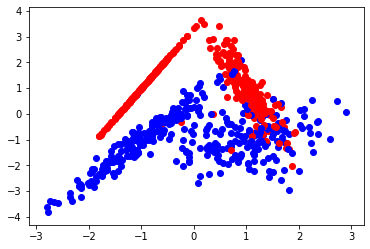

In [214]:
plot_data(X,Y)

In [210]:
core = KMean(X, features, class_count, iteration_count)
p, ms, e = core.kmean() 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


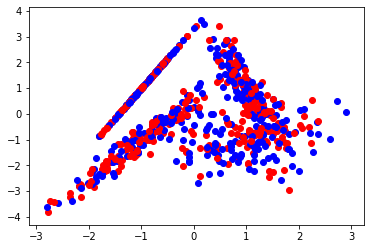

In [215]:
plot_data(X, p)

<div dir='rtl'>
<h3>ب (۱۰ نمره)</h3>

با استفاده از دستورات زیر دیتاست جدید ایجاد کنید. سپس الگوریتم‌های 
Kmeans
و 
GMM
را روی آن‌ها اجرا کنید

در نهایت نتیجه‌ی خوشه‌بندی را بصری‌سازی کنید و نتایج بدست آمده را با هم مقایسه نمایید.


---

برای بصری‌سازی می‌توانید از کتابخانه‌های آماده استفاده کنید.
</div>

In [250]:
from sklearn.datasets.samples_generator import make_moons
X, Y = make_moons(n_samples=700, noise=0.2)
X = np.array(X)
features = 2
class_count = 2
iteration_count = 20
gmm_diff = 0.1

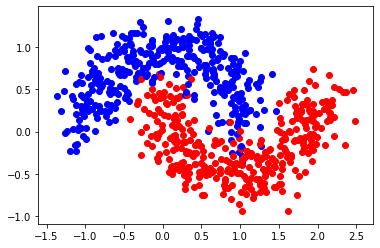

In [251]:
plot_data(X, Y)

In [252]:
moon_kmean = KMean(X, features, class_count, iteration_count)
p, ms, e = moon_kmean.kmean()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


In [253]:
M = Measurement()
print('purity: ', M.purity(Y, p))
print('rand_index: ', M.rand_index(Y, p))

purity:  0.76
rand_index:  0.6346781115879828


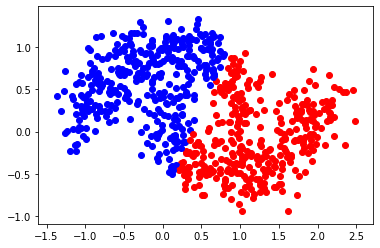

In [254]:
plot_data(X,p)

In [255]:
moon_gmm = GMM(X, features, class_count)
p, ms, ds, ps, run_count = moon_gmm.predict(gmm_diff)

In [256]:
M = Measurement()
print('purity: ', M.purity(Y, p))
print('rand_index: ', M.rand_index(Y, p))

purity:  0.85
rand_index:  0.7446351931330472


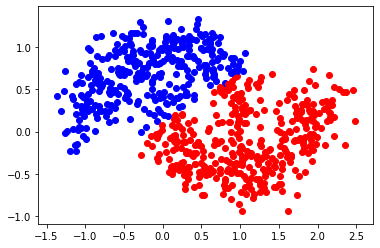

In [257]:
plot_data(X, p)

In [258]:
from sklearn.datasets.samples_generator import make_circles
X, Y = make_circles(n_samples=700, noise=0.2)
X = np.array(X)
fetures = 2
class_count = 2
iteration_count = 20
gmm_diff = 0.1

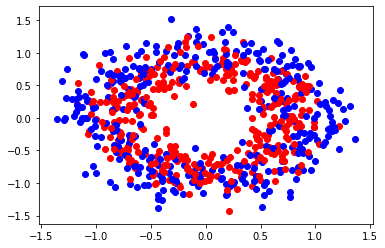

In [259]:
plot_data(X, Y)

In [260]:
circles_kmean = KMean(X, features, class_count, iteration_count)
p, ms, e = circles_kmean.kmean()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


In [261]:
M = Measurement()
print('purity: ', M.purity(Y, p))
print('rand_index: ', M.rand_index(Y, p))

purity:  0.5085714285714286
rand_index:  0.4994318414060903


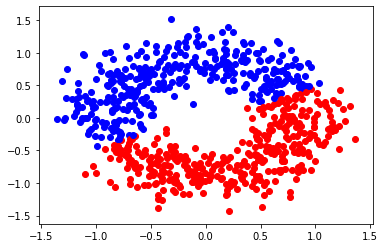

In [262]:
plot_data(X, p)

In [263]:
circles_gmm = GMM(X, features, class_count)
p, ms, ds, ps, run_count = circles_gmm.predict(gmm_diff)

In [264]:
M = Measurement()
print('purity: ', M.purity(Y, p))
print('rand_index: ', M.rand_index(Y, p))

purity:  0.5071428571428571
rand_index:  0.4993868792152054


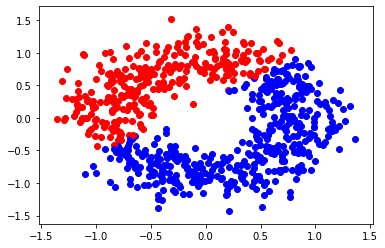

In [265]:
plot_data(X, p)

<div dir='rtl'>
تمامی خواسته‌های سوال در بالا پیاده سازی شده‌اند و کلاس‌های KMean و GMM برای محاسبه classification پیاده سازی شده‌اند و با استفاده از کلاس measurement به بررسی کیفیت classification می‌پردازیم
<br>
با توجه به نوع متفاوت داده‌ها در داده‌های moon و circles نتایج classification متفاوت است.
<br>
در داده‌ی moon روش GMM بهتر است زیرا داده‌های به صورت محلی توزیع شده‌اند. در روش kmean نتایج وابسته به انتخاب اولیه مراکز کلاس‌ها وابسته است. به همین دلیل روش GMM با توجه به روی کرد احتمالاتی خود بهتر از روش kmean عمل می‌کند.
<br>
اما در داده circles که داده‌ها بسیار به هم دیگر نزدیک هستند هر دوی روش‌ها عملکرد نسبتا نامطلوبی دارند و به صورت رندم classification را انجام داده‌اند.
</div>